In [8]:
import pandas as pd
import matplotlib.pyplot as plt # Import matplotlib for plotting 
import matplotlib.cm as cm # Import colormaps

In [2]:
age_file_path = "/global/scratch/users/yougsanghvi/suiciderate_adm0_who_gmd_countries_by_age_sex_selfinflicted_injuries_1950_2022.csv"
age_data = pd.read_csv(age_file_path)

In [8]:
age_data

,Region Code,WHO_Region,Country_Code,Country,Year,Sex,Age_group_code,Age_Group,Number_self_inflicted_deaths,Pct_self_inflicted_of_total_deaths,Age_standardized_suicide_rate_per_100000,Suicide_rate_per_100000
0,EU,Europe,ALB,Albania,1987,All,Age_unknown,Unknown,0.0,NaN,NaN,NaN
1,EU,Europe,ALB,Albania,1987,All,Age85_over,85+,1.0,0.044924,NaN,10.000000
2,EU,Europe,ALB,Albania,1987,All,Age80_84,80-84,0.0,0.000000,NaN,0.000000
3,EU,Europe,ALB,Albania,1987,All,Age75_79,75-79,1.0,0.047281,NaN,3.246753
4,EU,Europe,ALB,Albania,1987,All,Age70_74,70-74,0.0,0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
303697,AS,Asia,SAU,Saudi Arabia,2021,Female,Age65_69,65-69,4.0,0.152265,NaN,2.807451
303698,AS,Asia,SAU,Saudi Arabia,2021,Female,Age70_74,70-74,10.0,0.331565,NaN,11.169066
303699,AS,Asia,SAU,Saudi Arabia,2021,Female,Age75_79,75-79,14.0,0.385356,NaN,22.022967
303700,AS,Asia,SAU,Saudi Arabia,2021,Female,Age80_84,80-84,6.0,0.175336,NaN,15.500271


In [9]:
print(age_data['Age_Group'].unique())

['Unknown' '85+' '80-84' '75-79' '70-74' '65-69' '60-64' '55-59' '50-54'
 '45-49' '40-44' '35-39' '30-34' '25-29' '20-24' '15-19' '10-14' '5-9'
 '1-4' '0' 'All']


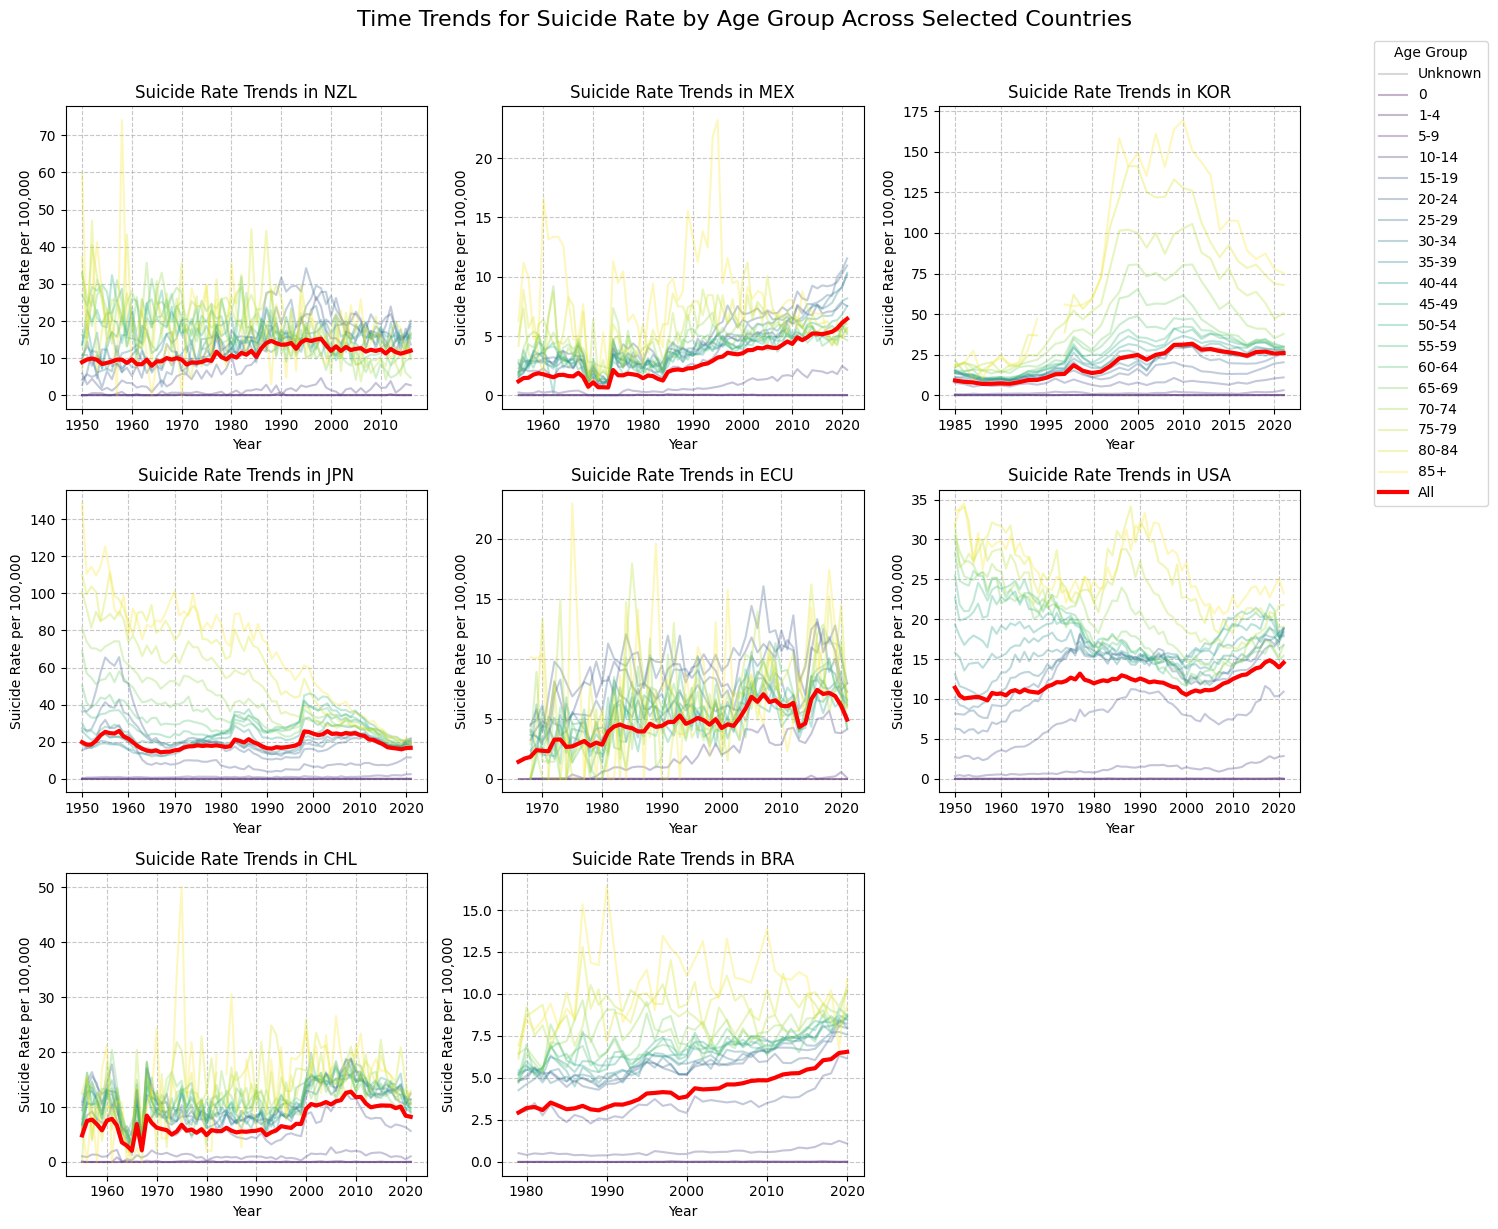

In [13]:

# --- Plotting Time Trends by Age Group for Specific Countries ---

# Define the list of countries for analysis
target_countries = ['NZL', 'MEX', 'KOR', 'JPN', 'ECU', 'USA', 'CHL', 'BRA']

# Ensure 'Year' is treated as a numerical type
age_data['Year'] = pd.to_numeric(age_data['Year'], errors='coerce')
# Drop rows where 'Year' is NaN after coercion
age_data.dropna(subset=['Year'], inplace=True)

# Define a custom sorting key for age groups to ensure logical order
def sort_age_group_key(age_group):
    if age_group == 'All':
        return 1000 # Place 'All' at the end for consistent legend sorting
    if age_group == 'Unknown':
        return -1 # Place 'Unknown' at the beginning
    if age_group == '0':
        return 0
    if '+' in age_group:
        return int(age_group.replace('+', ''))
    if '-' in age_group:
        start_age = int(age_group.split('-')[0])
        return start_age
    return 999 # Fallback for any other labels, though not expected here

# Get all unique age groups and sort them using the custom key
all_age_groups = age_data['Age_Group'].unique().tolist()
sorted_age_groups = sorted(all_age_groups, key=sort_age_group_key)

# Separate 'All' and 'Unknown' from the main age range groups for coloring
numeric_age_groups = [ag for ag in sorted_age_groups if ag not in ['All', 'Unknown']]

# Choose a colormap for the numeric age groups (e.g., 'viridis', 'plasma', 'cividis')
cmap = cm.viridis
colors = [cmap(i / (len(numeric_age_groups) - 1)) for i in range(len(numeric_age_groups))]

# Create a mapping from age group label to color
age_group_to_color = {}
j = 0
for ag in sorted_age_groups:
    if ag == 'All':
        age_group_to_color[ag] = 'red' # Distinct color for 'All'
    elif ag == 'Unknown':
        age_group_to_color[ag] = 'gray' # Distinct color for 'Unknown'
    elif ag in numeric_age_groups: # Ensure we only apply gradient to numeric groups
        age_group_to_color[ag] = colors[j]
        j += 1
    else:
        age_group_to_color[ag] = 'black' # Fallback for unexpected labels


# Create a figure to hold all subplots
num_countries = len(target_countries)
ncols = 3
nrows = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), sharex=False, sharey=False)
axes = axes.flatten()

# Iterate through each target country and create a separate plot
for i, country_code in enumerate(target_countries):
    country_data = age_data[age_data['Country_Code'] == country_code].copy()

    if not country_data.empty:
        country_grouped_data = country_data.groupby(['Year', 'Age_Group'])['Suicide_rate_per_100000'].mean().unstack()

        # Plot on the current subplot axis
        # Ensure that only columns (age groups) that have corresponding colors are plotted
        # Also, plot in a sorted order to ensure consistent line drawing
        age_groups_in_country_data = [col for col in country_grouped_data.columns if col in age_group_to_color]
        sorted_age_groups_for_plot = sorted(age_groups_in_country_data, key=sort_age_group_key)

        for age_group in sorted_age_groups_for_plot:
            line_color = age_group_to_color.get(age_group, 'black') # Default to black if not found

            if age_group == 'All':
                country_grouped_data[age_group].plot(ax=axes[i], legend=False,
                                                     color=line_color, linewidth=3, alpha=1.0)
            else:
                country_grouped_data[age_group].plot(ax=axes[i], legend=False,
                                                     color=line_color, linewidth=1.5, alpha=0.3)

        axes[i].set_title(f'Suicide Rate Trends in {country_code}')
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel('Suicide Rate per 100,000')
        axes[i].grid(True, linestyle='--', alpha=0.7)
    else:
        axes[i].set_title(f'No data for {country_code}')
        axes[i].set_visible(False)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Create a single legend for the entire figure
handles, labels = [], []

# Use the globally sorted age groups for legend consistency
for age_group_label in sorted_age_groups:
    color = age_group_to_color.get(age_group_label, 'black')
    if age_group_label == 'All':
        line, = plt.plot([], [], label=age_group_label, color=color, linewidth=3, alpha=1.0)
    else:
        line, = plt.plot([], [], label=age_group_label, color=color, linewidth=1.5, alpha=0.3)
    handles.append(line)
    labels.append(age_group_label)

fig.suptitle('Time Trends for Suicide Rate by Age Group Across Selected Countries', fontsize=16, y=1.02)
# Position the legend
fig.legend(handles, labels, title='Age Group', loc='upper right', bbox_to_anchor=(1.0, 1))
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()
